In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import corner
import astropy as ap
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.visualization import astropy_mpl_style
import pandas as pd
import math
import statistics
import scipy.ndimage as ndimage
import lenstronomy.Util.kernel_util as kernel_util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.Util import util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from memory_profiler import memory_usage
from lenstronomy.Plots.lens_plot import lens_model_plot
from lenstronomy.LensModel.lens_model import LensModel
plt.style.use(astropy_mpl_style)
%matplotlib inline


In [15]:
# general functions

def get_data(filename):
    """
    Input: filename
    Output: data table and image array
    """
    hdu_list = fits.open(filename)
    data = pd.DataFrame(hdu_list[2].data)  # get dataframe data
    image = hdu_list['IMAGE'].data  # get image data
    hdu_list.close()  # close
    return data, image


def plot_image(image_array):
    """
    Input: image array
    Output: plot of image
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image_array, origin='lower')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    plt.show()
    plt.close()


In [3]:
def approx_theta_E(center_x, center_y, x_images, y_images):
    """
    Input: Lens position (center_x, center_y) and image positions
    Output: estimated theta_E
    ** units must be in arcsec **
    """
    d = []

    for i in range(0, len(x_images)):
        x = float(x_images[i])
        y = float(y_images[i])
        x = center_x - x
        y = center_y - y
        dist = math.sqrt(x ** 2 + y ** 2)
        d.append(dist)

    theta_E = statistics.mean(d)
    print(f"'Estimated theta_E': {round(theta_E,2)}")
    return theta_E

In [4]:
def model_plot_all_bands(modelPlot):
    f, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # set row names: names must be in same order as multi_band_list
    band_names = [
#         'G', 'R',
                  'I']

    for index, band_name in enumerate(band_names):
        axes[0].set_title(str(band_name)+'-Band')  # set row title

        # plot observed, reconstructed, residual, and magnification plots
        modelPlot.data_plot(ax=axes[0], band_index=index)
        modelPlot.model_plot(ax=axes[1], image_names=True, band_index=index)
        modelPlot.normalized_residual_plot(ax=axes[2], v_min=-6, v_max=6, band_index=index)
        modelPlot.magnification_plot(ax=axes[3], band_index=index)
        
    plt.show()
    plt.close()

In [5]:
# psf function
def set_pixel_psf(coadd_id, band_index):
    """
    Input: coadd_id and band_index (g=0, r=1, i=2)
    Output: PIXEL psf model from fits file
    """
    # get data from fits file
    psf_filename = filepath + 'stars.fits'  # psf model from near field star
    psf_data, psf_image = get_data(psf_filename)

    # index by candidate's coadd_id
    psf_row = psf_data[psf_data['COADD_OBJECT_ID_CAND'] == coadd_id].index[0]  

    # crop kernel to odd number
    kernel = psf_image[psf_row, band_index, 0:45, 0:45]
    kernel_centered = kernel_util.center_kernel(kernel, iterations=20)
    kernel_nice = kernel_util.pixel_kernel(kernel_centered, subgrid_res=7)

    kernel_size = 13
    kernel_cut = kernel_util.cut_psf(kernel_centered, kernel_size)
    kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
    plot_image(kernel_cut)
    return kwargs_psf


In [6]:
# background_rms functions
def get_hist_stats(flat_image):
    """
    Input: 1d numpy array of image (flattened image)
           note: to flatten an image use '1d_array = 2d_array.flatten()'
    Output: number of bins for histogram based on spread of data,
            integer values of min and max (used for range of x-axis)
            root mean square value
    """
    min_int = math.floor(np.amin(flat_image))  # round min down to int
    max_int = math.ceil(np.amax(flat_image))  # round max up to int
    Bins = abs(min_int)+max_int  # num bins = one per integer value
    rms = np.sqrt(np.mean(flat_image**2))  # calculate rms
    return Bins, min_int, max_int, rms


def get_rms_fast(filename, coadd_id, crop):
    """
    Short Version:
    Input: filename, coadd_id of image, and background region
           region = crop = [[x_lower, x_upper], [y_lower, y_upper]]
    Output: rms_list (g,r,i)
    """
    data, image = get_data(filename)
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    # crop g,r,i bands to region
    g_crop = image[row, 0, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    r_crop = image[row, 1, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    i_crop = image[row, 2, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]

    # list of flattened images (1d image arrays)
    band_flats = [g_crop.flatten(), r_crop.flatten(), i_crop.flatten()]
    rms_list = []  # rms values will be saved here and returned

    # loop to get rms for each band
    for index, flat_image in enumerate(band_flats):
        _, _, _, rms = get_hist_stats(flat_image)  # get rms
        rms_list.append(rms)  # save rms

    return rms_list


In [7]:
def add_mask(band, kwargs_data, kwargs_psf, mask_2d):
    """
    Input: band (g,r,i) plus corresponding kwargs_data and kwargs_psf,
           kwargs_numerics
    Output: kwargs_data with masked image
    """
    # settings
    data_class = ImageData(**kwargs_data)
    psf_class = PSF(**kwargs_psf)
    kwargs_numerics = {'supersampling_factor': 1,
                       'supersampling_convolution': False}
    imageFit = ImageLinearFit(data_class=data_class,
                              psf_class=psf_class,
                              kwargs_numerics=kwargs_numerics,
                              likelihood_mask=mask_2d)
    # apply mask to image
    mask_1d = imageFit.image2array_masked(band)
    masked_image = imageFit.array_masked2image(mask_1d)

    # update kwargs_data with masked image
    kwargs_data.update({'image_data': masked_image})

    return kwargs_data, masked_image

In [8]:
# set filenames
filepath = '/Users/gilliancartwright/Desktop/summerproject/DES data/'  # personal file path
filename = filepath + 'Rob_candidates.fits'  # pre-cropped images
psf_filename = filepath + 'stars.fits'  # near field bright star psf
rms_filename = filepath + 'Rob_candidates_larger.fits'  # more background

# show data table for reference
data, image = get_data(filename)
data.head(3)


COADD_OBJECT_ID      TILENAME  HPIX_16384  HPIX_4096  DNF_ZMEAN_SOF  \
0       1400263522  DES0336-2915  2354916223  147182263       0.938449   
1       1325853948  DES0242-0041  1163420627   72713789       0.006323   
2       1087262176  DES0038-4414  2318857161  144928572       0.545765   

          RA        DEC  FLUX_RADIUS_G  FLUX_RADIUS_R  FLUX_RADIUS_I  ...  \
0  53.898900 -28.912203       3.962615       4.879757       4.983489  ...   
1  40.969310  -0.619002      10.245866      10.665524      11.179090  ...   
2  10.155908 -44.437518       5.865641       5.180269       5.163048  ...   

   FWHM_WMEAN_G  FWHM_WMEAN_R  FWHM_WMEAN_I  FWHM_WMEAN_Z  SKYBRITE_WMEAN_G  \
0       1.09654      0.943639      0.817035      0.899360        390.652008   
1       1.09442      0.956736      0.894366      0.889644        459.313995   
2       1.28928      1.035290      1.025070      0.777657        406.477997   

   SKYBRITE_WMEAN_R  SKYBRITE_WMEAN_I  SKYBRITE_WMEAN_Z           NAME  \
0        947.728027       3299.189941       7099.970215  DES-691022126   
1       1283.849976       3451.110107       8414.360352  DES-701263907   
2       1063.030029       2966.409912       8586.750000  DES-699919273   

    NAME_FOLDER  
0  DES0336-2915  
1  DES0242-0041  
2  DES0038-4414  

[3 rows x 36 columns]

In [9]:
# DES camera specifics
exp_time = 90.  # exposure time
numPix = 46  # number of pixels in image
deltaPix = 0.2637  # pixel size in arcsec


In [20]:
# MODEL
def model(coadd_id, kwargs_lens_initial, kwargs_light_initial,
          x_images, y_images, psf_type, rms_list, mask_list):
    """
    INPUT: coadd_id,
           initial lens mass and light model params,
           image positions in arcsec,
           psf choice (GAUSSIAN or PIXEL),
           list of background rms values (ordered G,R,I),
           list of masks or None
    OUTPUT: RGB image,
            observed image, modeled image, normalized residuals, critical curves and caustics (each band)
            and results of PSO and MCMC fitting
    """
    # Image data
    data, image = get_data(filename)
    # index data frame by coadd_id
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    g = image[row, 0, :, :] # get image array
    r = image[row, 1, :, :]
    i = image[row, 2, :, :]

    fwhm_g = data.iloc[row, 27] # get fwhm
    fwhm_r = data.iloc[row, 28]
    fwhm_i = data.iloc[row, 29]

    rms_g = rms_list[0]  # get background_rms
    rms_r = rms_list[1]
    rms_i = rms_list[2]

    # set models to use
    # input for point source is image positions, not source position
    lens_model_list = ['SIE']
    lens_light_model_list = ['SERSIC_ELLIPSE']
    point_source_list = ['LENSED_POSITION']

    # generate coordinate grid and image properties
    ra_grid, dec_grid, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix, deltaPix, subgrid_res=1, center_ra=0, center_dec=0, inverse=False)

    # generate image data for each band
    kwargs_data_g = {'background_rms': rms_g,  # calculated from background section
                     'exposure_time': exp_time,  # from DES camera
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,  # coords in ra, dec
                     'image_data': g}  # 2d image array

    kwargs_data_r = {'background_rms': rms_r,
                     'exposure_time': exp_time,
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,
                     'image_data': r}

    kwargs_data_i = {'background_rms': rms_i,
                     'exposure_time': exp_time,
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,
                     'image_data': i}

    # set kwargs_psf depending on psf_type
    if psf_type == 'GAUSSIAN':
        kwargs_psf_g = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_g,
                        'pixel_size': deltaPix, 'truncation': 4}
        kwargs_psf_r = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_r,
                        'pixel_size': deltaPix, 'truncation': 4}
        kwargs_psf_i = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_i,
                        'pixel_size': deltaPix, 'truncation': 4}

    # psf from near field bright star
    elif psf_type == 'PIXEL':
        kwargs_psf_g = set_pixel_psf(coadd_id, 0)
        kwargs_psf_r = set_pixel_psf(coadd_id, 1)
        kwargs_psf_i = set_pixel_psf(coadd_id, 2)

    else:
        print("Invalid psf_type. Choose 'GAUSSIAN' or 'PIXEL'.")

    # Option to add mask(s)
    if mask_list:
        # get 2d grid for ra, dec
        ra_grid_2d = util.array2image(ra_grid)
        dec_grid_2d = util.array2image(dec_grid)

        # add each mask from mask_list
        for index in range(len(mask_list)):
            # generate mask
            mask = mask_list[index]
            mask_2d = mask_util.mask_center_2d(center_x=mask.get('mask_x'),
                                               center_y=mask.get('mask_y'),
                                               r=mask.get('mask_r'),
                                               x_grid=ra_grid_2d,
                                               y_grid=dec_grid_2d)

            # add mask to each band
            kwargs_data_g, g = add_mask(g, kwargs_data_g, kwargs_psf_g, mask_2d)
            kwargs_data_r, r = add_mask(r, kwargs_data_r, kwargs_psf_r, mask_2d)
            kwargs_data_i, i = add_mask(i, kwargs_data_i, kwargs_psf_i, mask_2d)
        
        image_likelihood_mask_list = [g, r, i]
        
        # plot each band with mask(s) for reference
#         plot_image(g)
#         plot_image(r)
        plot_image(i)

    elif mask_list == None:
        image_likelihood_mask_list=None
    else:
        print('Please add mask or set mask_list=None')


    # Settings for model
    kwargs_numerics = {'supersampling_factor': 1,
                       'supersampling_convolution': False}

    # combine models
    kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'point_source_model_list': point_source_list,
                    'additional_images_list': [False],
                    'fixed_magnification_list': [False]}  # not modeling flux ratios here

    num_images = len(x_images)  # number of images
    kwargs_constraints = {'num_point_source_list': [num_images],
                          'joint_lens_with_light': [[0, 0, ['center_x', 'center_y']]]}  # lens mass and light will vary together now

    kwargs_likelihood = {'check_bounds': True,
                         'force_no_add_image': True,
                         'source_marg': False,
                         'image_position_uncertainty': 0.1,  # 1 sigma gaussian uncertainty in image positions
                         'check_matched_source_position': True,  # check that the image positions trace back to the same source position
                         'check_positive_flux': True,  # punish models with non-physical fluxes
                         'source_position_tolerance': 0.01,
                         'source_position_sigma': 0.01,
                         'image_likelihood': True,
                         'image_likelihood_mask_list': image_likelihood_mask_list  # apply mask to likelihood
                        }  # compute only I-Band


    # Combine bands for modeling
    g_band = [kwargs_data_g, kwargs_psf_g, kwargs_numerics]
    r_band = [kwargs_data_r, kwargs_psf_r, kwargs_numerics]
    i_band = [kwargs_data_i, kwargs_psf_i, kwargs_numerics]

    multi_band_list = [
#         g_band, r_band, 
                       i_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list,
#                          'multi_band_type': 'multi-linear'
                        }

    # Add parameters to model:
    # lens
    kwargs_lens_fixed = [{}]  # fixed parameters
    kwargs_lens_init = [kwargs_lens_initial]  # initial input
    kwargs_lens_sigma = [{'theta_E': 0.1, 'e1': 0.05, 'e2': 0.05,
                          'center_x': 0.01, 'center_y': 0.01}]  # step sizes
    kwargs_lower_lens = [{'theta_E': theta_E - 0.7, 'e1': -0.6, 'e2': -0.6,
                          'center_x': center_x - 0.75, 'center_y': center_y-0.75}]  # lower bounds
    kwargs_upper_lens = [{'theta_E': theta_E + 0.7, 'e1': 0.6, 'e2': 0.6,
                          'center_x': center_x + 0.75, 'center_y': center_y+0.75}]  # upper bounds

    # lens light
    kwargs_lens_light_fixed = [{}]  # fix the light since it is what is measured
    kwargs_lens_light_init = [kwargs_light_initial]
    kwargs_lens_light_sigma = [{'R_sersic': 1, 'n_sersic': 1,
                                'e1': 0.05, 'e2': 0.05,
                                'center_x': 0.01, 'center_y': 0.01}]
    kwargs_lower_lens_light = [{'R_sersic': 0.01, 'n_sersic': 0.01,
                                'e1': -0.6, 'e2': -0.6,
                                'center_x': center_x-0.75, 'center_y': center_y-0.75}]
    kwargs_upper_lens_light = [{'R_sersic': 20, 'n_sersic': 20.,
                                'e1': 0.6, 'e2': 0.6,
                                'center_x': center_x+0.75, 'center_y': center_y+0.75}]

    # point source image positions
    fixed_ps = [{}]
    kwargs_ps_init = [{'ra_image': x_images, 'dec_image': y_images}]
    kwargs_ps_sigma = [{'ra_image': [0.01] * num_images,
                        'dec_image': [0.01] * num_images}]
    kwargs_lower_ps = [{'ra_image': [i-0.75 for i in x_images],
                        'dec_image': [i-0.75 for i in y_images]}]
    kwargs_upper_ps = [{'ra_image': [i+0.75 for i in x_images],
                        'dec_image': [i+0.75 for i in y_images]}]

    # combine params
    lens_params = [kwargs_lens_init,
                   kwargs_lens_sigma,
                   kwargs_lens_fixed,
                   kwargs_lower_lens,
                   kwargs_upper_lens]

    lens_light_params = [kwargs_lens_light_init,
                         kwargs_lens_light_sigma,
                         kwargs_lens_light_fixed,
                         kwargs_lower_lens_light,
                         kwargs_upper_lens_light]

    ps_params = [kwargs_ps_init,
                 kwargs_ps_sigma,
                 fixed_ps,
                 kwargs_lower_ps,
                 kwargs_upper_ps]

    kwargs_params = {'lens_model': lens_params,
                     'lens_light_model': lens_light_params,
                     'point_source_model': ps_params}

    # Fitting
    fitting_seq = FittingSequence(kwargs_data_joint,
                                  kwargs_model,
                                  kwargs_constraints,
                                  kwargs_likelihood,
                                  kwargs_params)

    fitting_kwargs_list = [['PSO', {'sigma_scale': 1.,
                                    'n_particles': 400,
                                    'n_iterations': 400}],
                           ['MCMC', {'n_burn': 200,
                                     'n_run': 600,
                                     'walkerRatio': 10,
                                     'sigma_scale': .1}]]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    print(f"ra_images: {np.around(kwargs_result.get('kwargs_ps')[0].get('ra_image'), 2)}")
    print(f"dec_images: {np.around(kwargs_result.get('kwargs_ps')[0].get('dec_image'), 2)}")
    # Show final results
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, image_likelihood_mask_list, 
                          arrow_size=0.02, cmap_string="gist_heat")

    # plot RGB image
    rgb_image = ap.visualization.make_lupton_rgb(i, r, g, stretch=50, Q=10)
    plot_image(rgb_image)

    # plot observed, reconstructed, normalized residuals, and critical curves for each band
    model_plot_all_bands(modelPlot)

    # get lens model and image positions from results
    kwargs_lens_results = kwargs_result.get('kwargs_lens')
    x_images = kwargs_result.get('kwargs_ps')[0].get('ra_image')
    y_images = kwargs_result.get('kwargs_ps')[0].get('dec_image')
    kwargs_ps_results = [{'ra_image': x_images, 'dec_image': y_images}]

    # find source position from image positions
    lensModel = LensModel(lens_model_list=lens_model_list)
    pointSource = PointSource(point_source_type_list=point_source_list,
                              lensModel=lensModel)

    x_source_list, y_source_list = lensModel.ray_shooting(x_images, y_images, kwargs_lens_results)
    print('Ray-traced Source Positions:')
    print(f'ra: {x_source_list}')
    print(f'dec: {y_source_list}')

    # check that model is returning physical quantities: 
    check_impos = pointSource.check_image_positions(kwargs_ps_results, kwargs_lens_results, tolerance=0.1)
    check_flux = pointSource.check_positive_flux(kwargs_ps_results)
    print(f'Check Positions: {check_impos}')
    print(f'Check Fluxes: {check_flux}')

    # Results of MCMC chain
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list[1]

    # anowar's code:
    n_params = samples_mcmc.shape[1]
    n_walkers = 8 * n_params  # i don't know if this is right for my code?
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print(f'number of steps: {n_step}')
    print(f'number of walkers: {n_walkers}')
    print(f'number of parameters: {n_params}')

    chain = np.empty((n_walkers, n_step, n_params))

    for i in np.arange(n_params):
        samples = samples_mcmc[:, i].T
        chain[:,:,i] = samples.reshape((n_step, n_walkers)).T

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))
    
    for i in np.arange(n_params):
        for j in np.arange(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last-1], (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                    median_pos[1][last-1], (q84_pos[1][last-1]-q16_pos[1][last-1])/2
                   ]


    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last-1], (q84_pos[i][last-1]-q16_pos[i][last-1])/2))
       
        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2*len(param_mcmc)))
        #fig.tight_layout()
        plt.show()
        plt.close()
    
    
    n_sample = len(samples_mcmc)
    samples_mcmc_cut = samples_mcmc[int(n_sample * 1/2.):]
    plot = corner.corner(samples_mcmc_cut[:, :], labels=param_mcmc[:], show_titles=True)


In [21]:
psf_type = 'GAUSSIAN'

'Estimated theta_E': 1.67


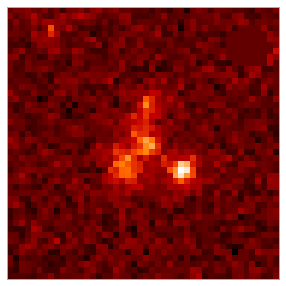

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
Converged after 380 iterations!
Best fit found:  -1115.7486711459856 [1.9062491498868253, 0.2500945415275414, 0.28203137545539153, 0.9202505481704614, 0.30459263483078675, -0.22199352256765328, 0.2446294300035352, -0.25953090697344866, -0.439715604878607, -1.1685488099673622, 0.2302287213775126, 1.7826434876989177, -0.8913757725667388, 1.8128767150204472, -1.2548399564629449]
-1.0874743383489138 reduced X^2 of best position
-1115.7486711459856 logL
2052.0 effective number of data points
[{'theta_E': 1.9062491498868253, 'e1': 0.2500945415275414, 'e2': 0.28203137545539153, 'center_x': -0.25953090697344866, 'center_y': -0.439715604878607}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.9202505481704614, 'n_sersic': 0.30459263483078675, 'e1': -0.22199352256765328, 'e2': 0.2446294300035352, 'center_x': -0.259530906973448

100%|██████████| 800/800 [04:33<00:00,  2.93it/s]

Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  200
Sampling iterations (in current run): 800
273.74412274360657 time taken for MCMC sampling
ra_images: [-1.16  0.23  1.78]
dec_images: [-0.89  1.79 -1.24]
-1.0780187776106869 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.0780187776106867



/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)


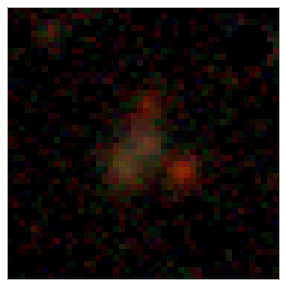

/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


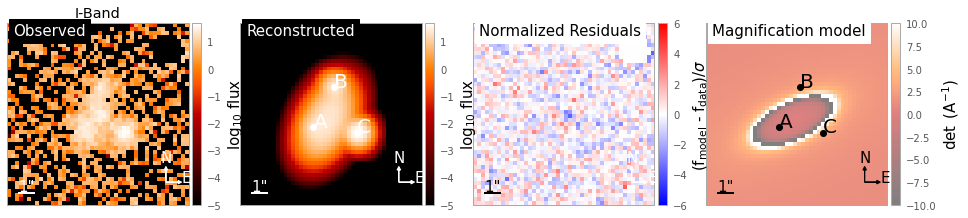

Ray-traced Source Positions:
ra: [0.22827544 0.2279268  0.2235796 ]
dec: [-0.15106503 -0.14625824 -0.14873783]
Check Positions: True
Check Fluxes: True
number of steps: 750
number of walkers: 120
number of parameters: 15
theta_E_lens0 1.8919 ± 0.0309
e1_lens0 0.2409 ± 0.0371
e2_lens0 0.2902 ± 0.0300
R_sersic_lens_light0 0.9408 ± 0.0504
n_sersic_lens_light0 0.3559 ± 0.1036
e1_lens_light0 -0.2196 ± 0.0409
e2_lens_light0 0.2509 ± 0.0354
center_x_lens_light0 -0.2401 ± 0.0549
center_y_lens_light0 -0.4280 ± 0.0589
ra_image -1.1480 ± 0.0652
ra_image 0.2147 ± 0.0584
ra_image 1.7838 ± 0.0184
dec_image -0.8816 ± 0.0511
dec_image 1.7973 ± 0.0495
dec_image -1.2542 ± 0.0173


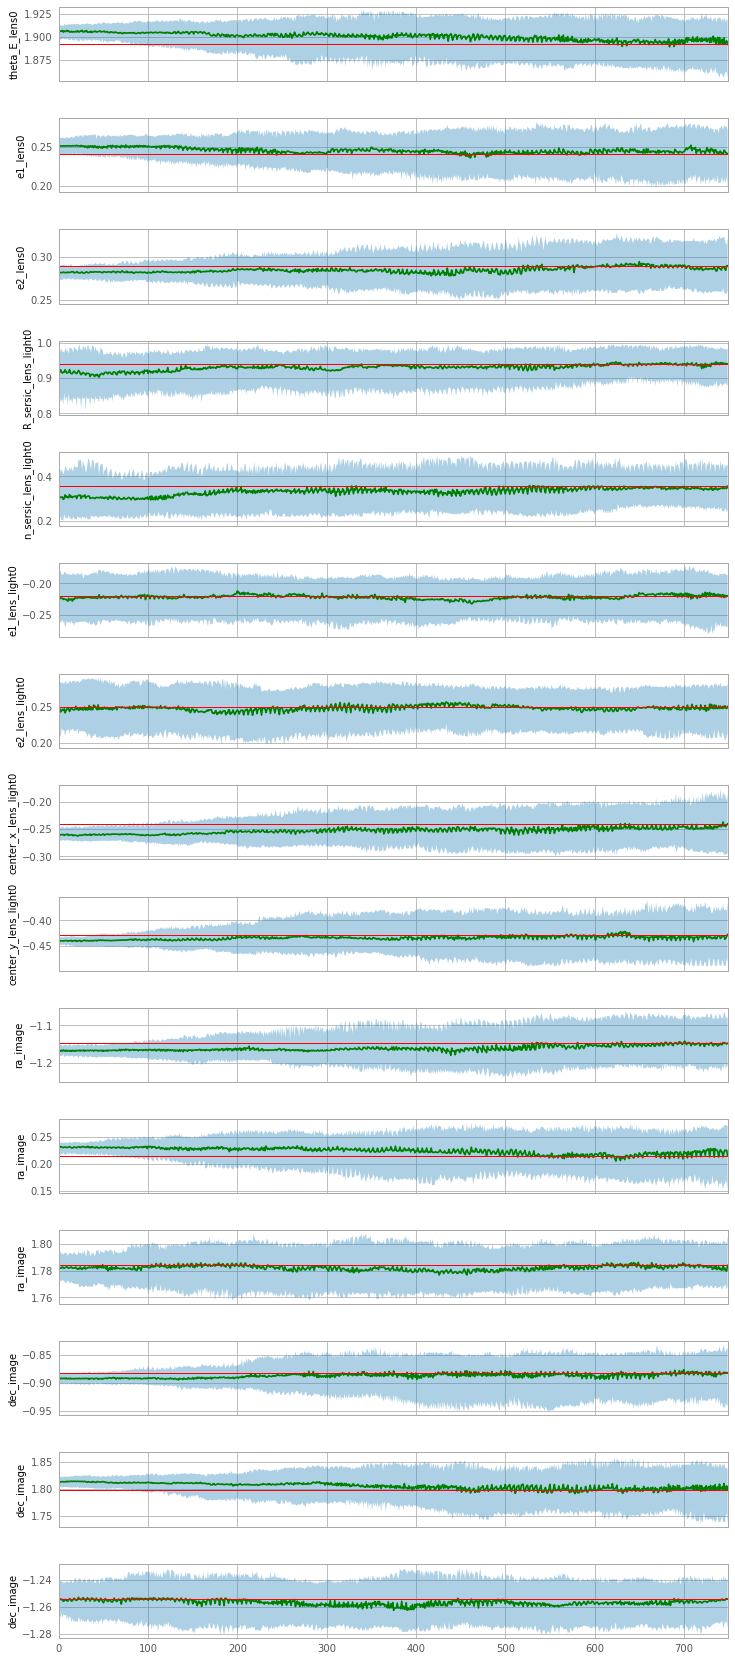

Total Memory Usage: 606.26953125


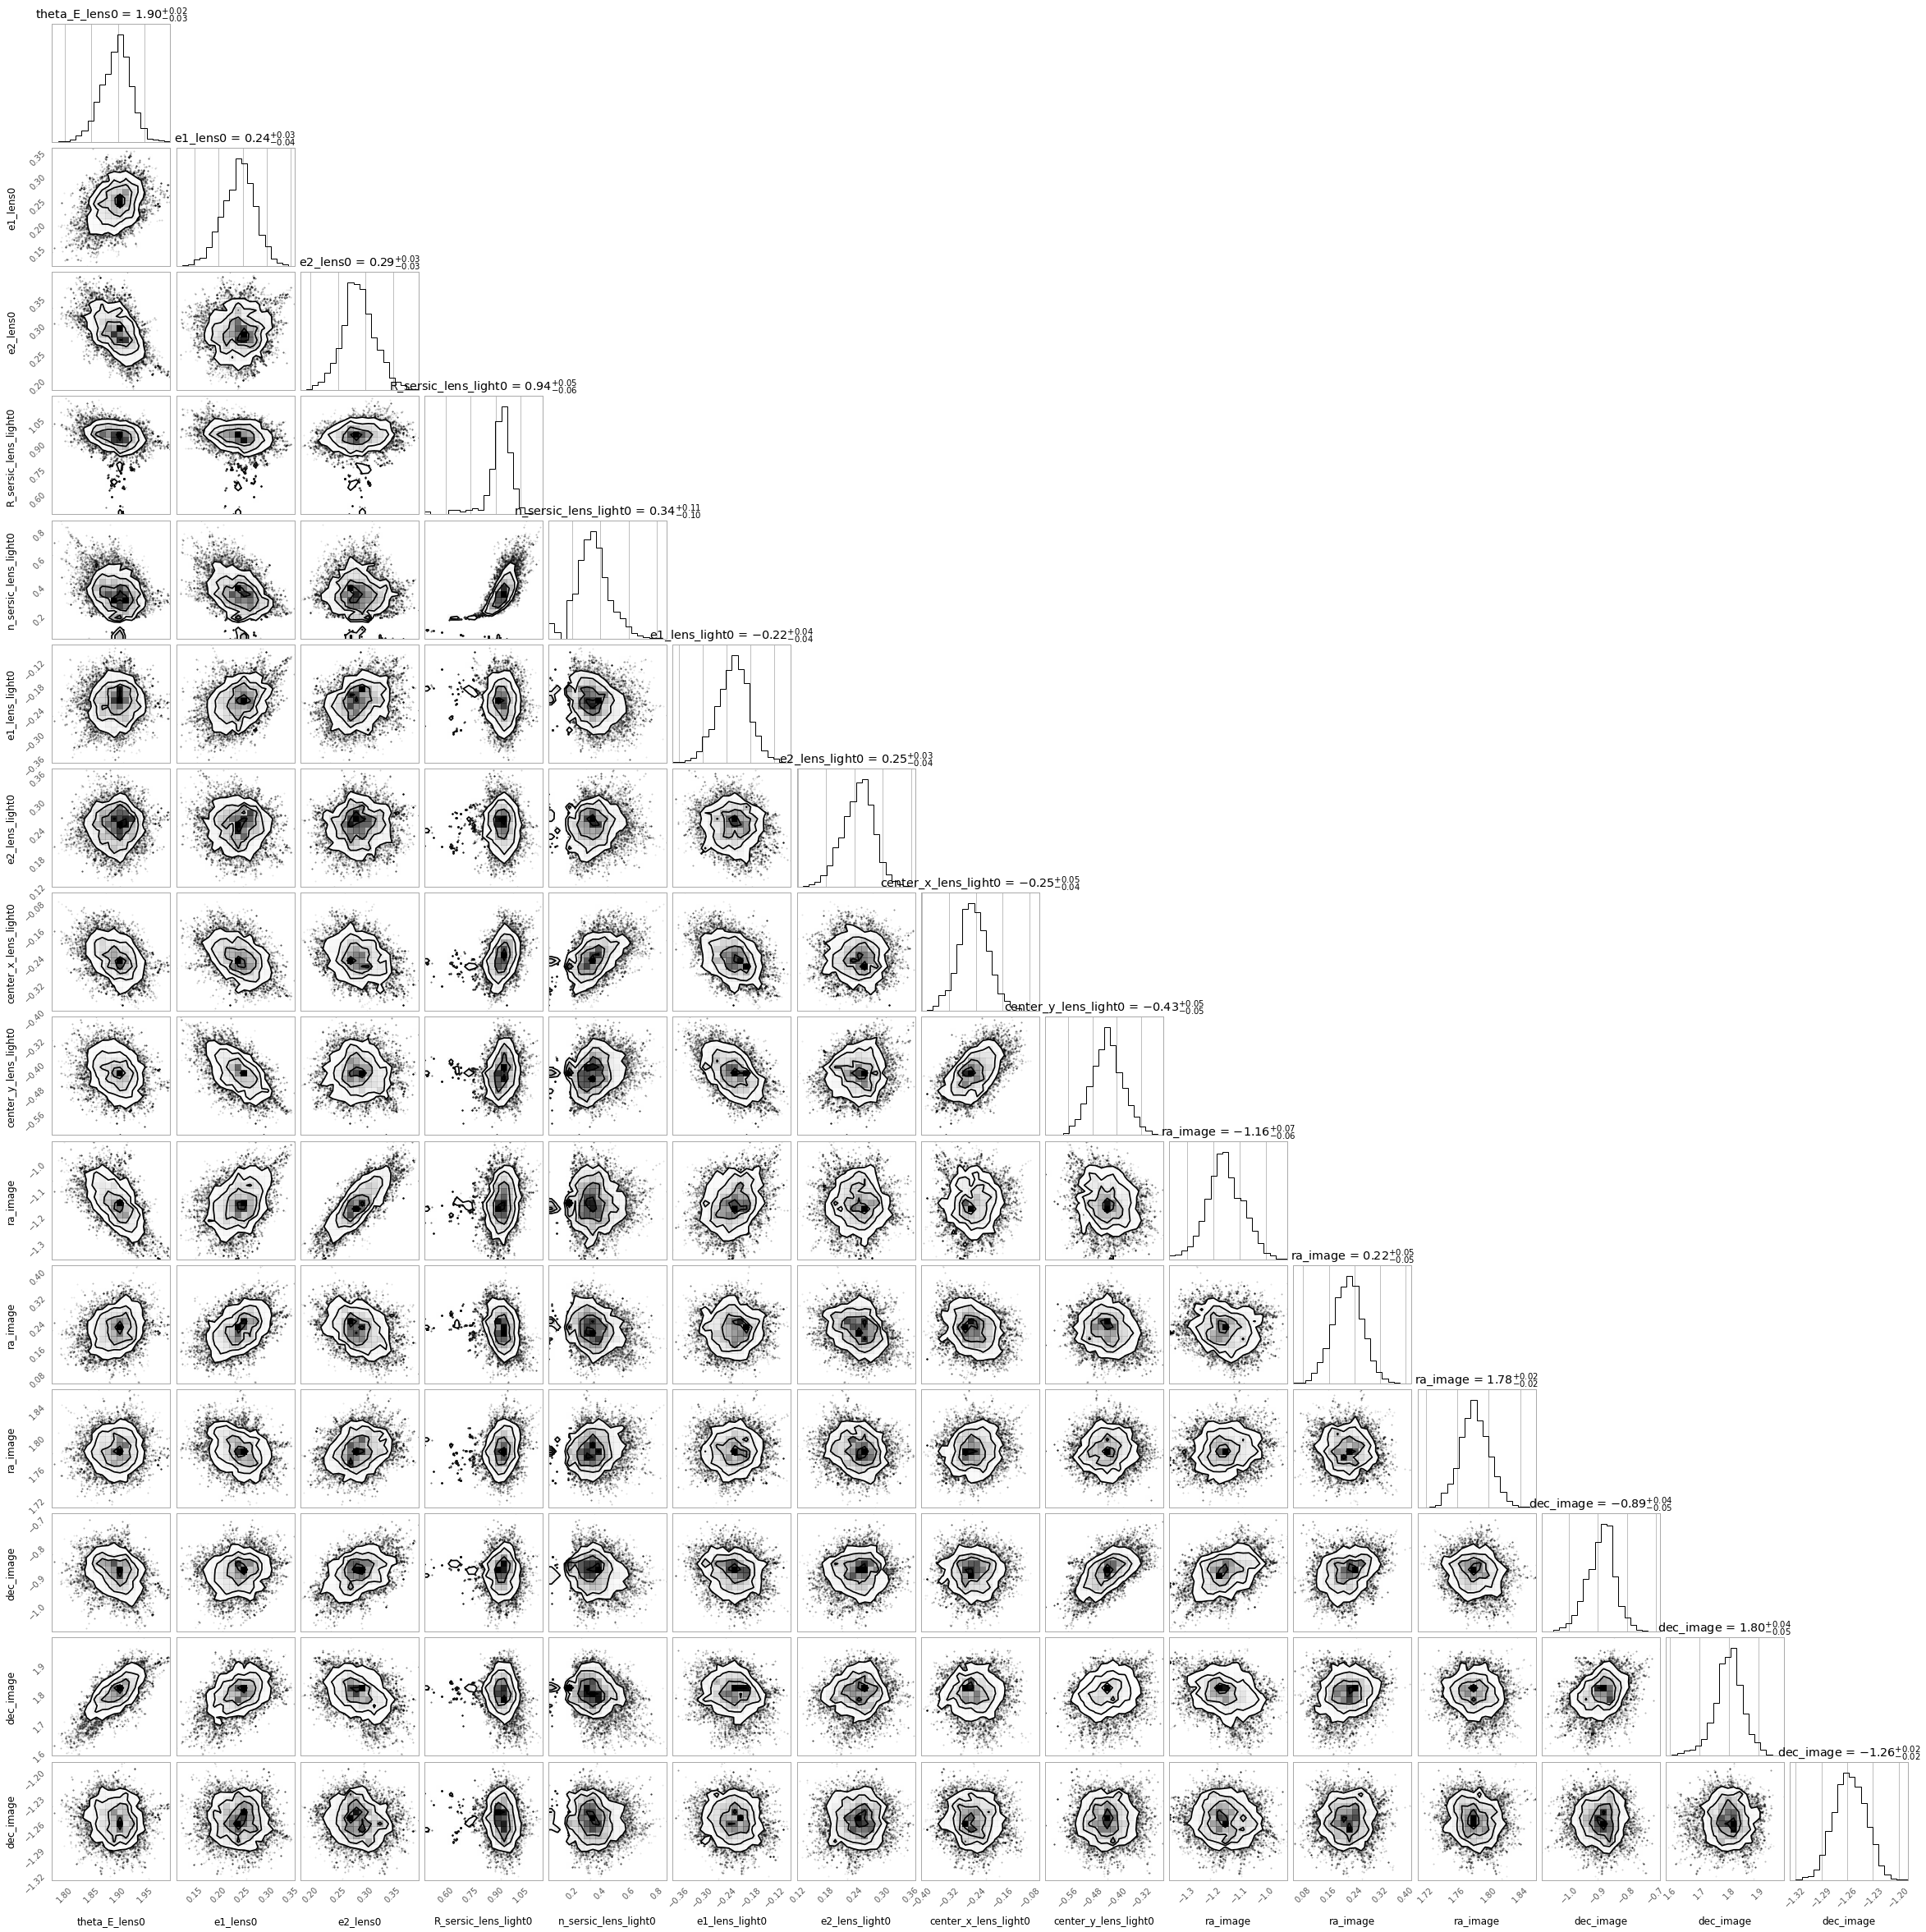

In [22]:
# DES_2915, coadd_id = 1400263522

# background_rms
crop = [[85, 114], [85, 114]]
rms_list = get_rms_fast(rms_filename, 1400263522, crop)

# image positions, measured
x_images = [-0.618, 0.374, 1.88]
y_images = [-0.863, 1.795, -1.083]

# lens position
center_x = 0.251
center_y = 0.104

# initial guesses for params
theta_E = approx_theta_E(center_x, center_y, x_images, y_images)
kwargs_lens_initial = {'theta_E': theta_E, 'e1': 0., 'e2': 0.,
                       'center_x': center_x, 'center_y': center_y}
kwargs_light_initial = {'R_sersic': 100, 'n_sersic': 2, 'e1': 0., 'e2': 0.,
                        'center_x': center_x, 'center_y': center_y}

# run model with memory tracker
mem_usage = memory_usage((model, (1400263522,
                                  kwargs_lens_initial,
                                  kwargs_light_initial,
                                  x_images, y_images,
                                  psf_type, rms_list,
                                  [{'mask_x': 4.7, 'mask_y': 4.3, 'mask_r': 1}]), ))

print(f"Total Memory Usage: {mem_usage[-1]}")
print("================================================================")

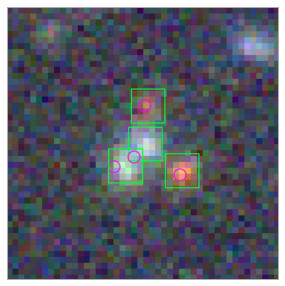

In [24]:
img_2915 = img.imread(filepath + 'singlelens2915.png')
plot_image(img_2915)

In the above image, the green squares represent the parameter space for the object positions with the center of each square (not marked) being the initial measured input. The red circles represent the position results from the modeling. As you can see, the lens position (center) does not match where I expected the lens to be based on the image.

'Estimated theta_E': 2.06
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
Max iteration reached! Stopping.
-17.00901103420783 reduced X^2 of best position
-17833.94806936691 logL
2097.0 effective number of data points
[{'theta_E': 2.2203706997218955, 'e1': -0.005577999765479399, 'e2': 0.004672960864419949, 'center_x': 1.4845017718483444, 'center_y': -1.411083015457069}] lens result
[] source result
[{'amp': 1, 'R_sersic': 18.342281214115026, 'n_sersic': 11.240195517254284, 'e1': -0.012054801614264388, 'e2': -0.1737368671374648, 'center_x': 1.4845017718483444, 'center_y': -1.411083015457069}] lens light result
[{'ra_image': array([-0.05256468, -0.22008521,  3.64443308]), 'dec_image': array([ 0.17563567, -2.81067448, -1.97778875]), 'point_amp': array([1., 1., 1.])}] point source result
{} special param result
356.780916929245 time used for  PSO


100%|██████████| 800/800 [04:05<00:00,  3.26it/s]

Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  200
Sampling iterations (in current run): 800
245.9255440235138 time taken for MCMC sampling
ra_images: [-0.05 -0.25  3.56]
dec_images: [ 0.18 -2.82 -1.98]
-16.71311139470038 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  16.71311139470038


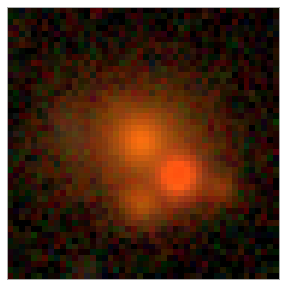

/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


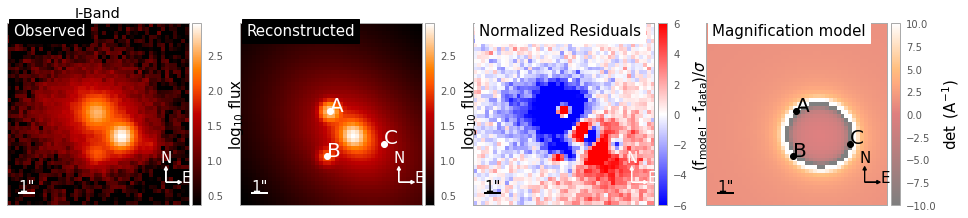

Ray-traced Source Positions:
ra: [1.44784471 1.44943611 1.45830525]
dec: [-1.40720403 -1.4143517  -1.41241941]
Check Positions: True
Check Fluxes: True
number of steps: 750
number of walkers: 120
number of parameters: 15
theta_E_lens0 2.2156 ± 0.0071
e1_lens0 0.0186 ± 0.0044
e2_lens0 -0.0155 ± 0.0037
R_sersic_lens_light0 19.5413 ± 0.3596
n_sersic_lens_light0 12.8662 ± 0.2469
e1_lens_light0 -0.0013 ± 0.0031
e2_lens_light0 -0.1577 ± 0.0043
center_x_lens_light0 1.5101 ± 0.0022
center_y_lens_light0 -1.4207 ± 0.0017
ra_image -0.0534 ± 0.0021
ra_image -0.2575 ± 0.0065
ra_image 3.5891 ± 0.0204
dec_image 0.1805 ± 0.0021
dec_image -2.8174 ± 0.0056
dec_image -1.9783 ± 0.0033


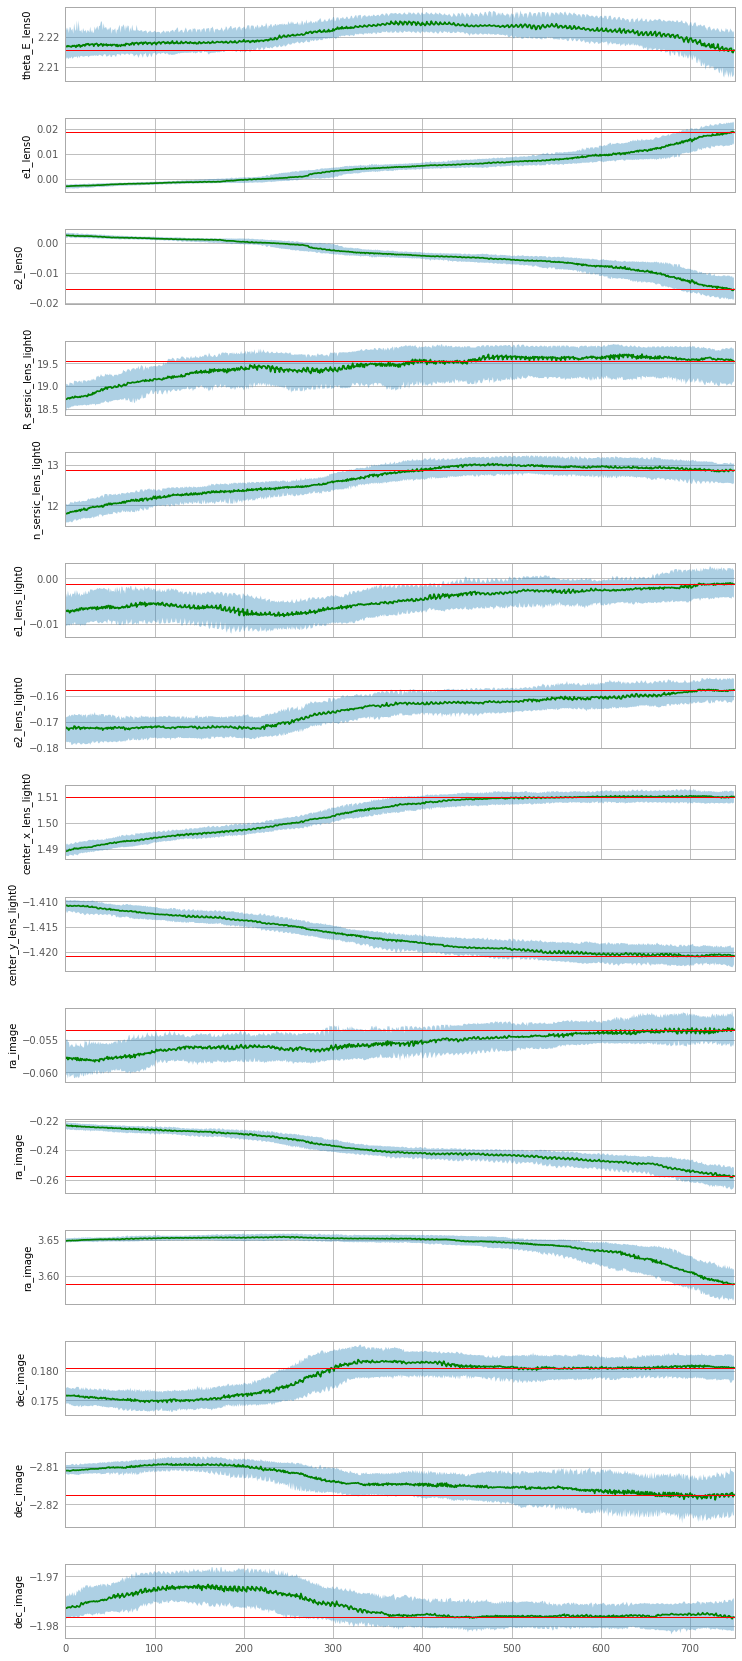

Total Memory Usage: 610.1015625


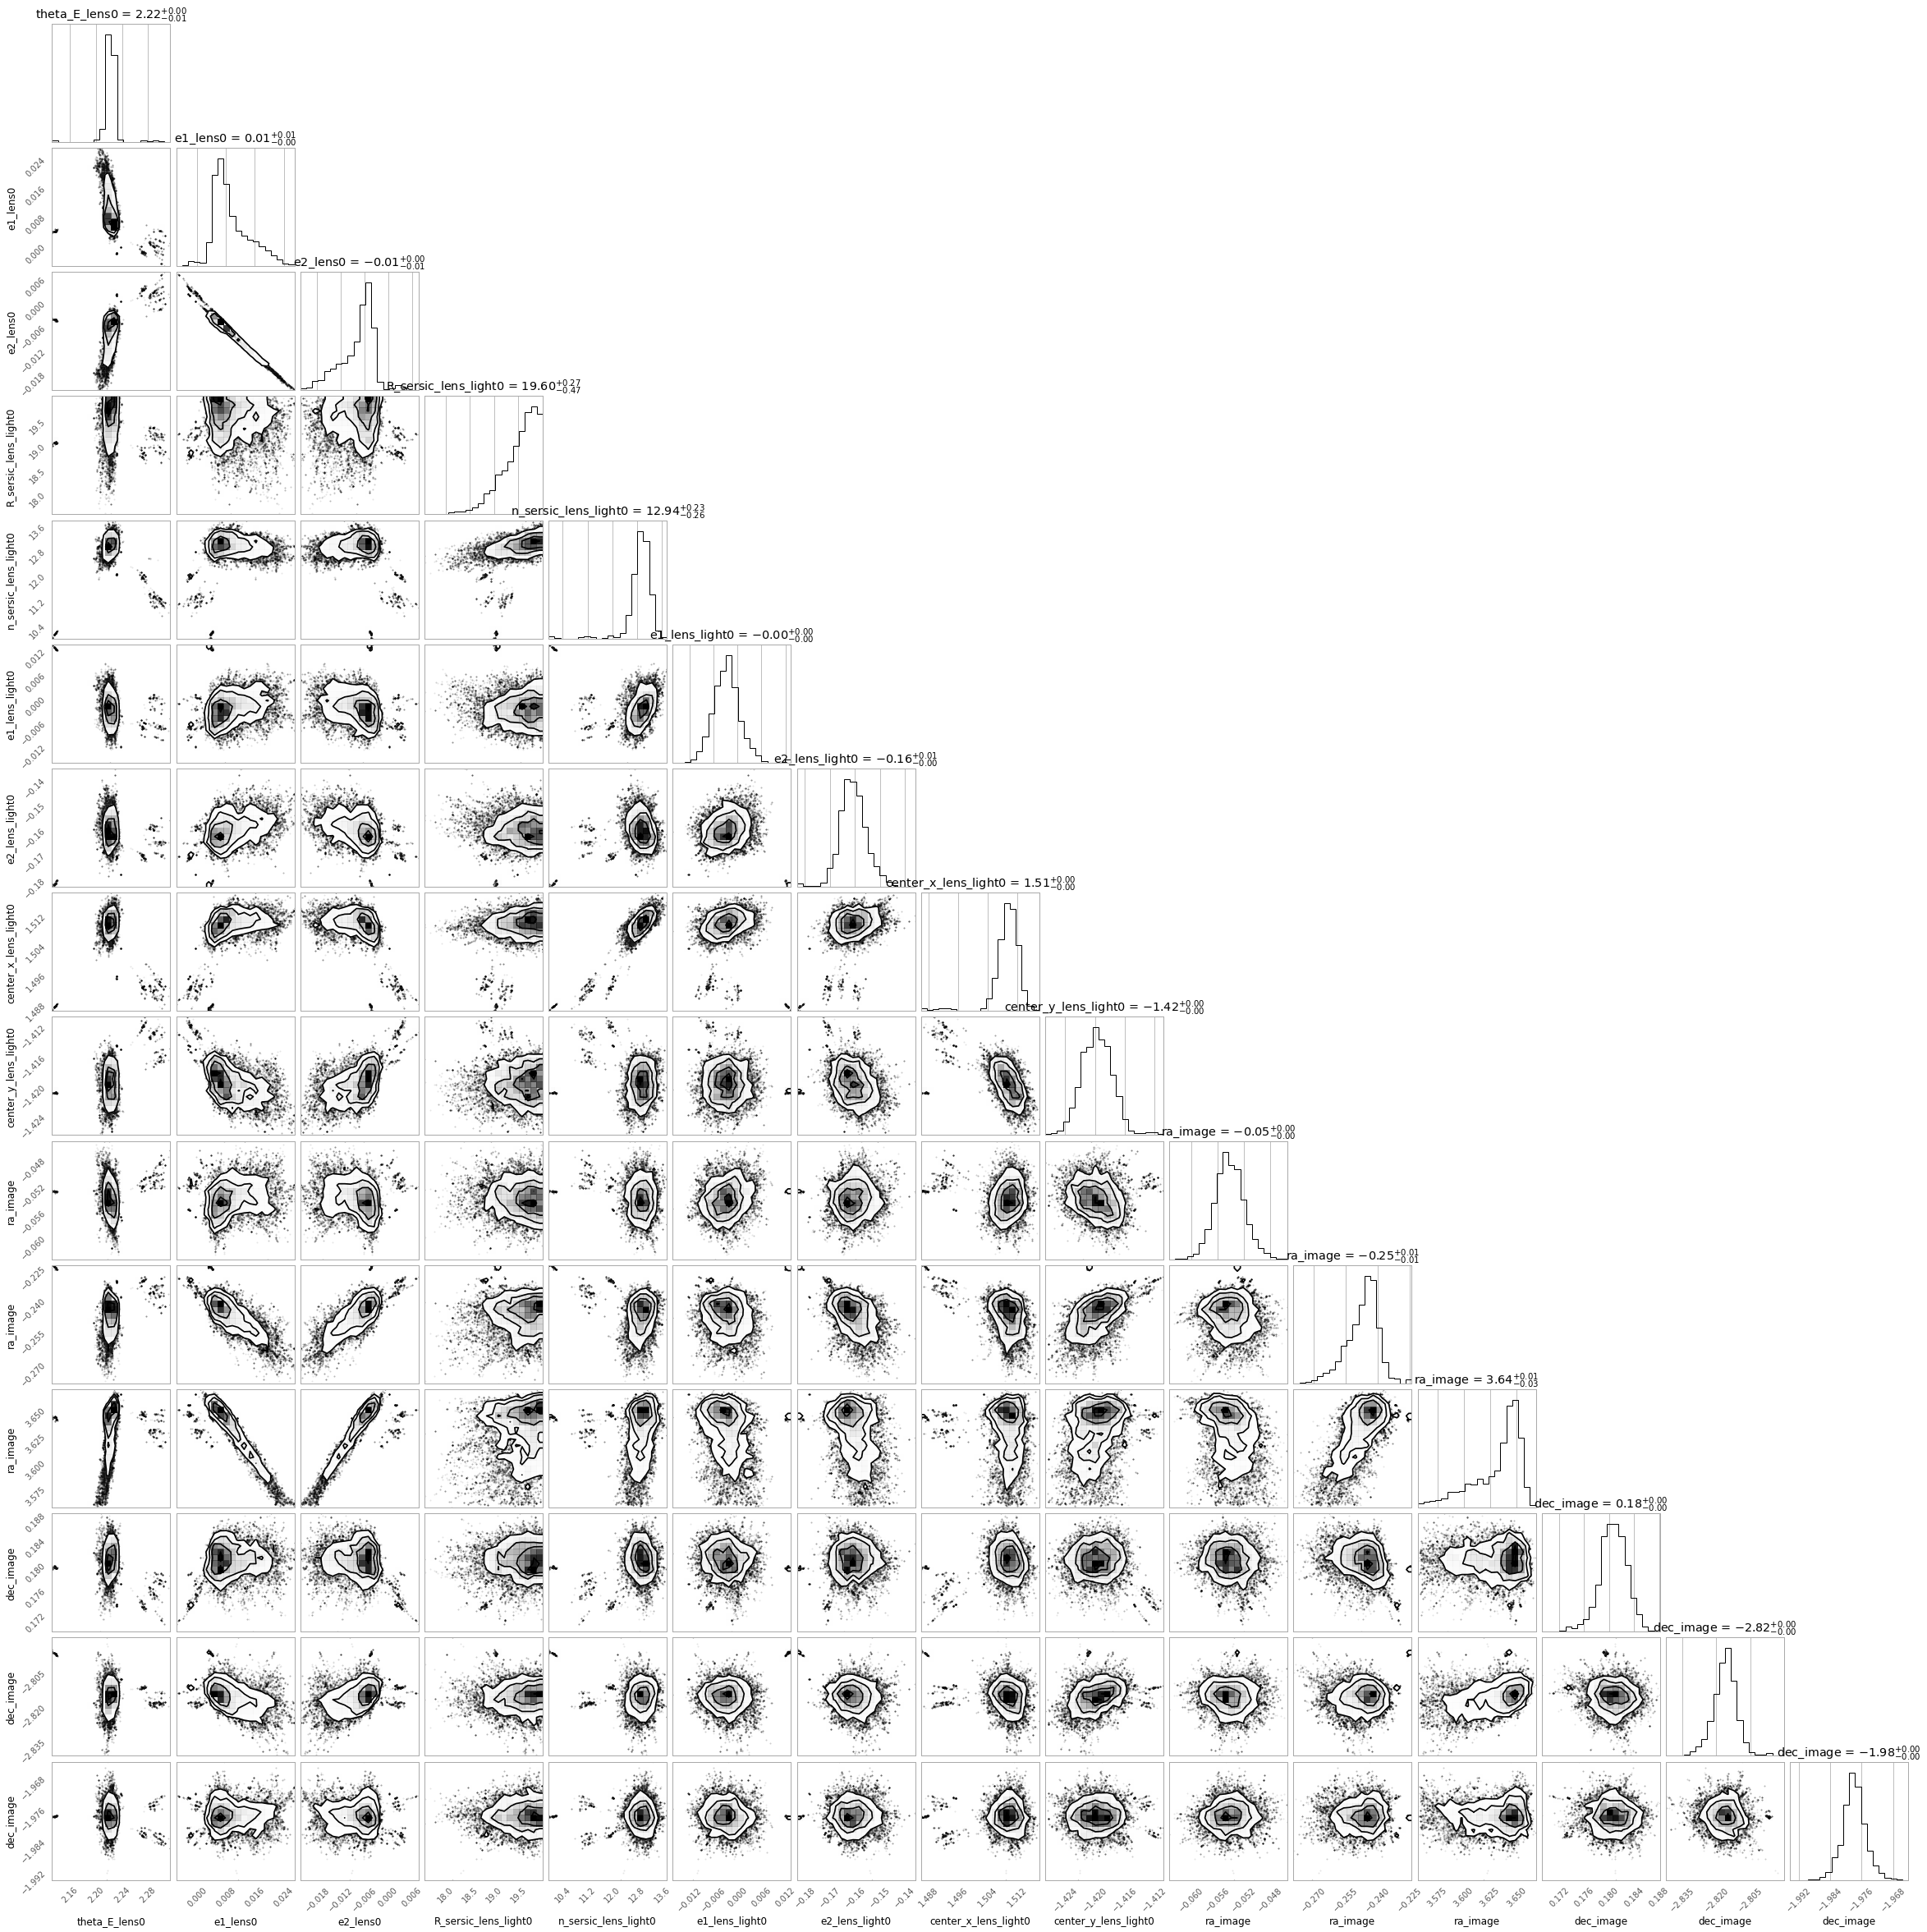

In [23]:
# DES_4414, coadd_id = 1087262176

# background_rms
crop = [[0, 35], [0, 35]]
rms_list = get_rms_fast(rms_filename, 1087262176, crop)

# lens position:
center_x = 1.68
center_y = -1.331

# image positions, measured
x_images = [0.068, 0.099, 3.623]
y_images = [0.201, -2.442, -1.878]

# initial guesses for params
theta_E = approx_theta_E(center_x, center_y, x_images, y_images)

kwargs_lens_initial = {'theta_E': theta_E, 'e1': 0., 'e2': 0,
                       'center_x': center_x, 'center_y': center_y}
kwargs_light_initial = {'R_sersic': 1, 'n_sersic': 2, 'e1': 0,
                        'e2': 0, 'center_x': center_x, 'center_y': center_y}

# run model with memory tracker
mem_usage = memory_usage((model, (1087262176,
                                  kwargs_lens_initial,
                                  kwargs_light_initial,
                                  x_images, y_images,
                                  psf_type, rms_list,
                                  None), ))

print(f"Total Memory Usage: {mem_usage[-1]}")
print("================================================================")


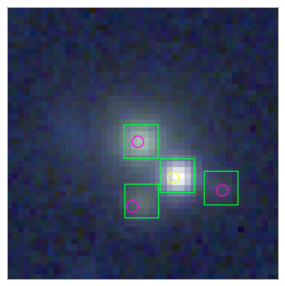

In [25]:
img_4414 = img.imread(filepath + 'singlelens4414.png')
plot_image(img_4414)

Again, the above image shows the parameter space outlined in green, and the results from the model as the circles. Red = image and Yellow = lens.